In [32]:
# magic
%load_ext autoreload
%autoreload 2 
#any changes to the function files will be updated on every run
#%pdb 1 
#where code fails, stops at that breakpoint and allows to examine potential error
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

In [2]:
from numba import vectorize, float64, guvectorize, jit

ImportError: Numba needs NumPy 1.21 or less

In [4]:
np.random.seed(6898)

In [6]:
from f_mean_adjust_ss_wasserstein import (alpha_stable, alpha_stable_ss, summary_statistics, mean_adjustment_summary_statistics)

In [7]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

## LOAD DATASET

In [8]:
actual_data = alpha_stable(1.8, 0.5, 1, 0, 200, 1)
actual_data

array([[-1.75454095,  0.06364251,  0.17838224,  3.91094968, -1.69946124,
         1.14189553,  0.15860387, -0.33582152,  5.58954453,  3.17043552,
        -0.8180322 ,  1.41864212, -0.05663035, -1.7940471 , -1.23415974,
        -0.50205508, -0.53787969, -0.92270598, -0.6519431 ,  1.19878179,
         4.6543093 ,  2.02094089, -1.71465436, -1.03405202,  1.7746176 ,
        -0.24464994, -0.14152402, -0.27737601, -1.07793331, -2.76181794,
        -0.8159597 ,  8.21195936, -1.52557809, -2.53213325, -0.93285844,
         0.7709601 , -1.27906719,  0.11566633,  1.22253277,  1.13778995,
         1.2514727 ,  0.45223848,  0.39449849,  1.09061486, -0.25245975,
         0.8439105 , -3.23281842,  2.99888162,  0.63651985, -0.68771279,
         1.17188   , -6.10762884, -1.5504376 , -1.52891999,  0.24804221,
        -0.96044672, -0.63952273, -0.1376288 ,  0.31428243, -2.73222301,
        -2.44688612,  0.8240769 ,  4.30468544,  1.13072982,  0.1621017 ,
        -1.7847421 ,  0.13156545, -0.03031964, -0.0

In [10]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([ 1.58297532,  0.31404455,  0.99630353, -0.01986152])

In [40]:
# Using previously simulated data for consistency
actual_summary_statistics = np.array([ 1.36495524,  0.27388675,  0.78684313, -0.08169088])

In [11]:
num_coeffs = np.shape(actual_summary_statistics)[0]
num_latent = np.shape(actual_summary_statistics)[0]
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [12]:
from multiprocessing import Pool
from functools import partial
pool = Pool(8)

## Training Wasserstein Gaussianing

In [13]:
wass_num_datasets = 6000
wass_n_samples = 30
maxG = 4

In [14]:
# Generating data to train the transform
wass_datasets = alpha_stable(1.8, 0.5, 1, 0, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = np.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])

In [15]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [19]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in range(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-10).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = int(np.argmin(bic_values) + 1)
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-10).fit(data)
    return best_mixture_obj, bestG

In [20]:
def grad_log_density_mixture(data, mixture_obj):
    mean_mixture_obj = mixture_obj.means_
    sigma_mixture_obj = mixture_obj.covariances_
    weights_mixture_obj = mixture_obj.weights_
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ my_inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ my_inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,num_coeffs)) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [21]:
# At current particles, fit mixture normal
mixture_obj, bestG = mixture_model_fit(wass_train_summary_statistics, maxG)

AttributeError: 'NoneType' object has no attribute 'split'

In [49]:
# Start training

# Hyperparams
patience_max = 20
patience = 0 
stop = 5000
eps = 0.01
t_w = 20

# Initialize empty chain
mixture_obj_seq = [0] * stop
bestG_seq = [0] * stop
mixture_obj_seq[0] = mixture_obj
bestG_seq[0] = bestG
lb = []
LB_Smoothed = []

In [50]:
for t in range(stop):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_obj)[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_obj)[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_obj = mixture_model_fit(wass_train_summary_statistics, maxG)[0]
    bestG = mixture_model_fit(wass_train_summary_statistics, maxG)[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq[t+1] = mixture_obj
    bestG_seq[t+1] = bestG

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break

LB -1.1463180887120012
LB -6.8214438807041535
LB -3.8201943585755234
LB -4.002419966428465
LB -3.2877819092842246
LB -3.067778122232961
LB -2.83797156223765
LB -2.2729939299880066
LB -2.3962397499542574
LB -1.925641681446658
LB -2.401502351882411
LB -1.5128462762934245
LB -1.477373446540183
LB -1.3115607130375038
LB -1.3143509512021334
LB -1.7323694651750798
LB -1.4394584183853487
LB -0.6624974114042181
LB -0.4792234204333147
LB -1.4899500238899408
LB Smoothed -2.329136717847129
LB Smoothed -1.9788327019118834
LB Smoothed -1.7905212198732645
LB Smoothed -1.586537162944856
LB Smoothed -1.4661179417417616
LB Smoothed -1.3414599618471115
LB Smoothed -1.2378655328954031
LB Smoothed -1.1321263582138776
LB Smoothed -0.9879154915745925
LB Smoothed -0.8643683989552065
LB Smoothed -0.7329170459037847
LB Smoothed -0.646824605539749
LB Smoothed -0.5437825643737844
LB Smoothed -0.4475362526572318
LB Smoothed -0.35748904640789086
LB Smoothed -0.22982065597565685
LB Smoothed -0.15790704664911062
LB 

<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

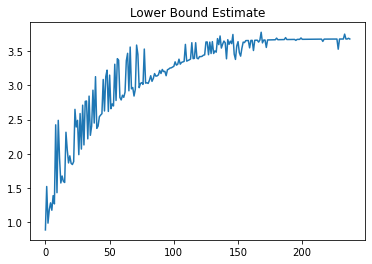

In [51]:
wass_lb_df = pd.DataFrame(np.array(lb[50:]))
plt.figure()
wass_lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

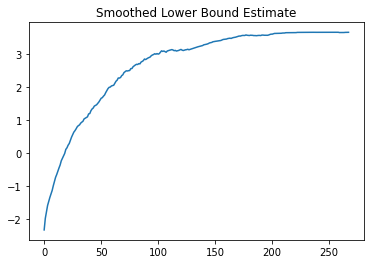

In [52]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

<AxesSubplot:>

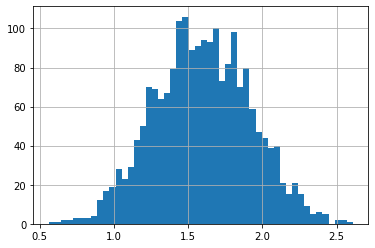

In [53]:
pd.Series(np.random.normal(np.mean(original_train_summary_statistics[:,0]),np.std(original_train_summary_statistics[:,0]), len(original_train_summary_statistics[:,0]))
).hist(bins = 50)

<AxesSubplot:>

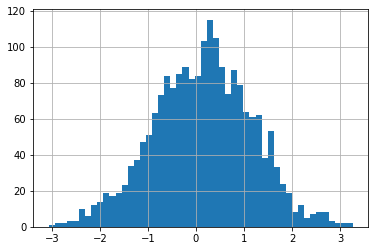

In [54]:
pd.Series(np.random.normal(np.mean(wass_train_summary_statistics[:,0]),np.std(wass_train_summary_statistics[:,0]), len(wass_train_summary_statistics[:,0]))
).hist(bins = 50)

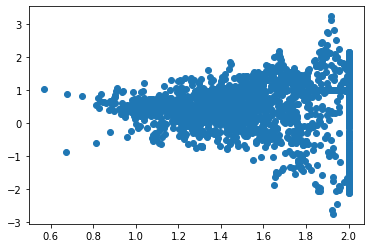

In [55]:
plt.scatter(original_train_summary_statistics[:,0], original_train_summary_statistics[:,1])

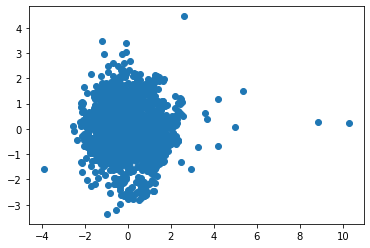

In [56]:
plt.scatter(wass_train_summary_statistics[:,0], wass_train_summary_statistics[:,1])

In [57]:
mixture_obj_seq = [i for i in mixture_obj_seq if i!=0]
mixture_obj_seq = mixture_obj_seq[:-10]
mixture_obj_seq

[GaussianMixture(n_components=4, reg_covar=1e-10),
 GaussianMixture(n_components=4, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=2, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=2, reg_covar=1e-10),
 GaussianMixture(n_components=2, reg_covar=1e-10),
 GaussianMixture(n_components=2, reg_covar=1e-10),
 GaussianMixture(n_components=2, reg_covar=1e-10),
 GaussianMixture(n_components=4, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=2, reg_covar=1e-10),
 GaussianMixture(n_components=2, reg_covar=1e-10),
 GaussianMixture(n_components=3

In [58]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [59]:
# Functions must be imported for multiprocessing to work
from functions_robust_wasserstein.f_gradient_lb_mean_wasserstein_nuissance import (fun_gradient_lb)

In [60]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        l_0_inv = my_inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)

                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [61]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[ 1.36495524,  0.27388675,  0.78684313, -0.08169088]])

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [62]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)
transformed_summary_statistics[0]

array([-0.63616352, -0.38603054, -0.24720713,  0.03164241])

In [63]:
vb = GVB(400, transformed_summary_statistics[0], 0.001, 2500, 100, 0.9, 0.9, 100, 100)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
  0%|          | 1/5000 [02:29<208:14:58, 149.97s/it]

LB -12.618698047859182


  0%|          | 2/5000 [04:29<183:37:26, 132.26s/it]

LB -12.703471928563488


  0%|          | 3/5000 [06:28<175:09:49, 126.19s/it]

LB -12.582108473849102


  0%|          | 4/5000 [08:32<173:57:46, 125.35s/it]

LB -12.589201627108785


  0%|          | 5/5000 [10:21<165:48:15, 119.50s/it]

LB -12.494400566934939


  0%|          | 6/5000 [12:10<160:21:50, 115.60s/it]

LB -12.843468125413326


  0%|          | 7/5000 [13:57<156:26:46, 112.80s/it]

LB -12.64546732055999


  0%|          | 8/5000 [15:43<153:38:33, 110.80s/it]

LB -12.664877431983893


  0%|          | 9/5000 [17:31<152:29:23, 109.99s/it]

LB -12.352190088910186


  0%|          | 10/5000 [19:18<150:54:56, 108.88s/it]

LB -12.525762136606831


  0%|          | 11/5000 [21:05<150:05:48, 108.31s/it]

LB -12.604794402261678


  0%|          | 12/5000 [22:53<149:51:56, 108.16s/it]

LB -12.283077820868487


  0%|          | 13/5000 [24:40<149:20:24, 107.81s/it]

LB -12.573256790312739


  0%|          | 14/5000 [27:04<164:50:43, 119.02s/it]

LB -12.443825692880436


  0%|          | 15/5000 [29:13<168:44:48, 121.86s/it]

LB -12.315494387429139


  0%|          | 16/5000 [31:01<163:07:58, 117.83s/it]

LB -12.3086344991317


  0%|          | 17/5000 [32:50<159:05:57, 114.94s/it]

LB -12.435149303016717


  0%|          | 18/5000 [34:37<156:01:14, 112.74s/it]

LB -12.66729071796


  0%|          | 19/5000 [36:25<153:49:35, 111.18s/it]

LB -12.495740198289214


  0%|          | 20/5000 [38:11<151:47:49, 109.73s/it]

LB -12.526793739130683


  0%|          | 21/5000 [40:31<164:06:13, 118.65s/it]

LB -12.570902050913105


  0%|          | 22/5000 [42:19<159:59:46, 115.71s/it]

LB -12.497356672965557


  0%|          | 23/5000 [44:05<155:56:47, 112.80s/it]

LB -12.76340968033969


  0%|          | 24/5000 [46:34<170:52:03, 123.62s/it]

LB -12.552806949730043


  0%|          | 25/5000 [48:21<163:39:55, 118.43s/it]

LB -12.440478271736865


  1%|          | 26/5000 [50:09<159:32:30, 115.47s/it]

LB -12.308917555849456


  1%|          | 27/5000 [52:31<170:22:36, 123.34s/it]

LB -12.609013061833503


  1%|          | 28/5000 [54:18<163:29:19, 118.37s/it]

LB -12.365128774837363


  1%|          | 29/5000 [56:05<158:46:54, 114.99s/it]

LB -12.668275705129677


  1%|          | 30/5000 [57:53<155:52:05, 112.90s/it]

LB -12.293012986739221


  1%|          | 31/5000 [59:39<153:15:40, 111.04s/it]

LB -12.500682736864091


  1%|          | 32/5000 [1:01:27<151:40:33, 109.91s/it]

LB -12.349881233975362


  1%|          | 33/5000 [1:03:15<150:54:34, 109.38s/it]

LB -12.346208749556046


  1%|          | 34/5000 [1:05:28<160:53:18, 116.63s/it]

LB -12.349394952948582


  1%|          | 35/5000 [1:07:48<170:30:08, 123.63s/it]

LB -12.344631519700979


  1%|          | 36/5000 [1:10:11<178:12:03, 129.24s/it]

LB -12.433059970257796


  1%|          | 37/5000 [1:12:52<191:30:06, 138.91s/it]

LB -12.396339010490728


  1%|          | 38/5000 [1:15:06<189:18:23, 137.34s/it]

LB -12.040331021724366


  1%|          | 39/5000 [1:17:33<193:22:34, 140.33s/it]

LB -12.441414560229708


  1%|          | 40/5000 [1:19:59<195:32:24, 141.92s/it]

LB -12.335796939930509


  1%|          | 41/5000 [1:22:31<199:35:33, 144.89s/it]

LB -12.21103659286936


  1%|          | 42/5000 [1:24:37<191:44:32, 139.22s/it]

LB -12.322632793763082


  1%|          | 43/5000 [1:26:46<187:47:09, 136.38s/it]

LB -12.383402204011752


  1%|          | 44/5000 [1:28:51<182:46:27, 132.77s/it]

LB -12.44862644171774


  1%|          | 45/5000 [1:30:52<177:56:44, 129.28s/it]

LB -12.253086227410398


  1%|          | 46/5000 [1:32:55<175:11:30, 127.31s/it]

LB -12.305422855879435


  1%|          | 47/5000 [1:34:44<167:37:50, 121.84s/it]

LB -12.267938044755837


  1%|          | 48/5000 [1:36:37<163:58:59, 119.21s/it]

LB -12.133906372843953


  1%|          | 49/5000 [1:39:16<180:33:25, 131.29s/it]

LB -12.030336294871422


  1%|          | 50/5000 [1:41:42<186:18:49, 135.50s/it]

LB -12.129153185079172


  1%|          | 51/5000 [1:44:01<187:52:04, 136.66s/it]

LB -12.087791313238846


  1%|          | 52/5000 [1:46:29<192:34:43, 140.11s/it]

LB -12.144778181925933


  1%|          | 53/5000 [1:48:54<194:34:23, 141.59s/it]

LB -12.10760789478507


  1%|          | 54/5000 [1:51:08<191:20:52, 139.27s/it]

LB -12.121642845156842


  1%|          | 55/5000 [1:53:32<193:09:59, 140.63s/it]

LB -12.330570330544186


  1%|          | 56/5000 [1:55:59<195:42:16, 142.50s/it]

LB -12.234812831464492


  1%|          | 57/5000 [1:58:44<205:03:23, 149.34s/it]

LB -12.113175028850016


  1%|          | 58/5000 [2:01:00<199:34:30, 145.38s/it]

LB -12.14298532047701


  1%|          | 59/5000 [2:03:28<200:26:55, 146.05s/it]

LB -12.261337398246628


  1%|          | 60/5000 [2:06:36<217:42:56, 158.66s/it]

LB -12.106185078539676


  1%|          | 61/5000 [2:09:46<230:30:01, 168.01s/it]

LB -11.91947482221697


  1%|          | 62/5000 [2:12:19<224:26:54, 163.63s/it]

LB -12.300232683796985


  1%|▏         | 63/5000 [2:15:35<237:46:33, 173.38s/it]

LB -12.385563342108433


  1%|▏         | 64/5000 [2:18:05<227:59:13, 166.28s/it]

LB -11.966673995978686


  1%|▏         | 65/5000 [2:20:29<218:38:56, 159.50s/it]

LB -12.088566069593973


  1%|▏         | 66/5000 [2:22:48<210:10:50, 153.35s/it]

LB -12.161889516858734


  1%|▏         | 67/5000 [2:25:00<201:22:25, 146.96s/it]

LB -12.096552508126681


  1%|▏         | 68/5000 [2:28:12<219:52:45, 160.50s/it]

LB -12.220459050427753


  1%|▏         | 69/5000 [2:30:41<215:13:13, 157.13s/it]

LB -12.162411273426908


  1%|▏         | 70/5000 [2:34:15<238:33:11, 174.20s/it]

LB -12.161919832016613


  1%|▏         | 71/5000 [2:36:43<227:53:59, 166.45s/it]

LB -12.033018783193624


  1%|▏         | 72/5000 [2:39:12<220:44:46, 161.26s/it]

LB -11.966631368852171


  1%|▏         | 73/5000 [2:43:27<259:02:14, 189.27s/it]

LB -12.429587435119481


  1%|▏         | 74/5000 [2:45:45<237:56:14, 173.89s/it]

LB -12.11595801503097


  2%|▏         | 75/5000 [2:48:03<223:17:17, 163.22s/it]

LB -12.127464494934081


  2%|▏         | 76/5000 [2:50:27<215:11:55, 157.33s/it]

LB -12.06361483126543


  2%|▏         | 77/5000 [2:52:44<207:00:06, 151.37s/it]

LB -11.908803773331876


  2%|▏         | 78/5000 [2:54:57<199:25:53, 145.87s/it]

LB -12.049746417373637


  2%|▏         | 79/5000 [2:57:16<196:31:21, 143.77s/it]

LB -11.97280962151866


  2%|▏         | 80/5000 [2:59:28<191:19:35, 140.00s/it]

LB -12.152668492018192


  2%|▏         | 81/5000 [3:01:39<187:55:12, 137.53s/it]

LB -12.080083253498865


  2%|▏         | 82/5000 [3:04:25<199:16:48, 145.87s/it]

LB -12.23622898970665


  2%|▏         | 83/5000 [3:06:47<197:43:19, 144.76s/it]

LB -12.119720558389847


  2%|▏         | 84/5000 [3:09:07<195:43:47, 143.33s/it]

LB -12.02532538350633


  2%|▏         | 85/5000 [3:11:38<198:59:57, 145.76s/it]

LB -12.152316044156846


  2%|▏         | 86/5000 [3:14:18<204:32:04, 149.84s/it]

LB -11.962984496926925


  2%|▏         | 87/5000 [3:16:37<200:23:02, 146.83s/it]

LB -11.94862871780709


  2%|▏         | 88/5000 [3:18:56<196:55:55, 144.33s/it]

LB -11.875937445788509


  2%|▏         | 89/5000 [3:21:17<195:41:42, 143.45s/it]

LB -11.886588504243234


  2%|▏         | 90/5000 [3:24:38<218:54:21, 160.50s/it]

LB -11.859873252881226


  2%|▏         | 91/5000 [3:27:19<219:17:17, 160.81s/it]

LB -11.773556670685702


  2%|▏         | 92/5000 [3:29:54<216:37:28, 158.89s/it]

LB -11.88163119163051


  2%|▏         | 93/5000 [3:32:22<212:16:27, 155.73s/it]

LB -11.8951885358878


  2%|▏         | 94/5000 [3:34:58<212:26:29, 155.89s/it]

LB -11.839961245237832


  2%|▏         | 95/5000 [3:37:32<211:44:41, 155.41s/it]

LB -12.115722854957507


  2%|▏         | 96/5000 [3:40:36<223:20:49, 163.96s/it]

LB -11.887889444292652


  2%|▏         | 97/5000 [3:43:09<218:50:05, 160.68s/it]

LB -11.924351663129658


  2%|▏         | 98/5000 [3:45:55<220:49:17, 162.17s/it]

LB -12.134906938904674


  2%|▏         | 99/5000 [3:48:42<222:43:26, 163.60s/it]

LB -12.078649394771876


  2%|▏         | 100/5000 [3:51:30<224:36:54, 165.02s/it]

LB -12.036421093580422


  2%|▏         | 101/5000 [3:54:35<232:31:07, 170.86s/it]

LB Smoothed -12.250489766672413


  2%|▏         | 102/5000 [3:57:31<234:42:07, 172.50s/it]

LB Smoothed -12.2424137851612


  2%|▏         | 103/5000 [4:00:35<239:14:09, 175.87s/it]

LB Smoothed -12.235335332640666


  2%|▏         | 104/5000 [4:03:36<241:21:10, 177.47s/it]

LB Smoothed -12.2301532827633


  2%|▏         | 105/5000 [5:35:24<2415:38:52, 1776.57s/it]

LB Smoothed -12.225882862481738


  2%|▏         | 106/5000 [5:39:14<1784:15:23, 1312.49s/it]

LB Smoothed -12.217051878285215


  2%|▏         | 107/5000 [5:42:57<1340:01:15, 985.91s/it] 

LB Smoothed -12.211136470062236


  2%|▏         | 108/5000 [5:46:26<1022:50:21, 752.70s/it]

LB Smoothed -12.202285702832308


  2%|▏         | 109/5000 [5:50:01<803:24:48, 591.35s/it] 

LB Smoothed -12.198121258136746


  2%|▏         | 110/5000 [5:53:36<649:55:36, 478.47s/it]

LB Smoothed -12.194119484407203


  2%|▏         | 111/5000 [5:57:26<548:40:53, 404.02s/it]

LB Smoothed -12.187099429144858


  2%|▏         | 112/5000 [6:00:56<469:27:14, 345.75s/it]

LB Smoothed -12.183970329374352


  2%|▏         | 113/5000 [6:04:26<414:09:01, 305.08s/it]

LB Smoothed -12.17757650525835


  2%|▏         | 114/5000 [6:08:04<378:35:05, 278.94s/it]

LB Smoothed -12.172539444986597


  2%|▏         | 115/5000 [6:11:42<353:25:43, 260.46s/it]

LB Smoothed -12.16810814091023


  2%|▏         | 116/5000 [6:15:10<332:24:42, 245.02s/it]

LB Smoothed -12.16463818550931


  2%|▏         | 117/5000 [6:19:05<327:56:53, 241.78s/it]

LB Smoothed -12.159970690702128


  2%|▏         | 118/5000 [6:22:41<317:34:24, 234.18s/it]

LB Smoothed -12.15132156420472


  2%|▏         | 119/5000 [6:26:15<309:15:15, 228.09s/it]

LB Smoothed -12.14564108148926


  2%|▏         | 120/5000 [6:29:47<302:42:45, 223.31s/it]

LB Smoothed -12.139999515501978


  2%|▏         | 121/5000 [6:33:20<298:31:04, 220.26s/it]

LB Smoothed -12.132197829801413


  2%|▏         | 122/5000 [6:37:06<300:48:11, 221.99s/it]

LB Smoothed -12.125249399695154


  2%|▏         | 123/5000 [6:43:38<369:31:02, 272.76s/it]

LB Smoothed -12.116974514629112


  2%|▏         | 124/5000 [6:51:53<460:00:13, 339.63s/it]

LB Smoothed -12.110875535041783


  2%|▎         | 125/5000 [6:55:36<412:14:49, 304.43s/it]

LB Smoothed -12.10665816121062


  3%|▎         | 126/5000 [6:59:15<377:28:29, 278.81s/it]

LB Smoothed -12.101662176435537


  3%|▎         | 127/5000 [7:02:58<354:43:50, 262.06s/it]

LB Smoothed -12.095752952074983


  3%|▎         | 128/5000 [7:06:34<336:19:34, 248.52s/it]

LB Smoothed -12.091506896080991


  3%|▎         | 129/5000 [7:10:12<323:28:54, 239.08s/it]

LB Smoothed -12.084117796212054


  3%|▎         | 130/5000 [7:13:54<316:39:19, 234.08s/it]

LB Smoothed -12.078886940374952


  3%|▎         | 131/5000 [7:17:44<315:02:28, 232.93s/it]

LB Smoothed -12.0738311766935


  3%|▎         | 132/5000 [7:21:18<307:24:48, 227.34s/it]

LB Smoothed -12.068676231359655


  3%|▎         | 133/5000 [7:24:53<302:20:33, 223.64s/it]

LB Smoothed -12.064834419630142


  3%|▎         | 134/5000 [7:28:29<298:54:41, 221.14s/it]

LB Smoothed -12.060212264615872


  3%|▎         | 135/5000 [7:31:08<273:33:01, 202.42s/it]

LB Smoothed -12.055609069446602


  3%|▎         | 136/5000 [7:33:45<255:04:57, 188.79s/it]

LB Smoothed -12.051494133365146


  3%|▎         | 137/5000 [7:36:25<243:22:25, 180.17s/it]

LB Smoothed -12.047888933181708


  3%|▎         | 138/5000 [7:40:02<258:17:01, 191.24s/it]

LB Smoothed -12.046583764166284


  3%|▎         | 139/5000 [7:43:16<259:27:24, 192.15s/it]

LB Smoothed -12.041031370443772


  3%|▎         | 140/5000 [7:45:59<247:49:22, 183.57s/it]

LB Smoothed -12.036938189817409


  3%|▎         | 141/5000 [7:48:43<239:33:29, 177.49s/it]

LB Smoothed -12.033845453752585


  3%|▎         | 142/5000 [7:51:26<233:48:18, 173.26s/it]

LB Smoothed -12.028815563064944


  3%|▎         | 143/5000 [7:54:10<229:51:27, 170.37s/it]

LB Smoothed -12.023723916790022


  3%|▎         | 144/5000 [7:56:50<225:35:18, 167.24s/it]

LB Smoothed -12.01618614782536


  3%|▎         | 145/5000 [7:59:30<222:32:06, 165.01s/it]

LB Smoothed -12.011154379463497


  3%|▎         | 146/5000 [8:02:13<222:00:53, 164.66s/it]

LB Smoothed -12.006175141210162


  3%|▎         | 147/5000 [8:04:58<221:56:03, 164.63s/it]

LB Smoothed -12.002392985115335


  3%|▎         | 148/5000 [8:07:39<220:36:00, 163.68s/it]

LB Smoothed -11.99982725564687


  3%|▎         | 149/5000 [8:10:17<218:17:02, 161.99s/it]

LB Smoothed -11.998579414794056


  3%|▎         | 150/5000 [8:12:59<218:14:28, 161.99s/it]

LB Smoothed -11.99424725898322


  3%|▎         | 151/5000 [8:15:43<218:55:51, 162.54s/it]

LB Smoothed -11.989066197134575


  3%|▎         | 152/5000 [8:18:27<219:30:06, 163.00s/it]

LB Smoothed -11.984854918801808


  3%|▎         | 153/5000 [8:21:10<219:09:35, 162.78s/it]

LB Smoothed -11.981193135778435


  3%|▎         | 154/5000 [8:23:50<218:11:55, 162.10s/it]

LB Smoothed -11.979155215045852


  3%|▎         | 155/5000 [8:26:34<218:46:41, 162.56s/it]

LB Smoothed -11.972939129894115


  3%|▎         | 156/5000 [8:29:19<219:59:32, 163.50s/it]

LB Smoothed -11.9673650507017


  3%|▎         | 157/5000 [8:32:03<220:02:26, 163.57s/it]

LB Smoothed -11.962800054509104


  3%|▎         | 158/5000 [8:34:46<219:33:50, 163.24s/it]

LB Smoothed -11.958787027685059


  3%|▎         | 159/5000 [8:37:27<218:49:26, 162.73s/it]

LB Smoothed -11.95461901948154


  3%|▎         | 160/5000 [8:40:13<219:54:26, 163.57s/it]

LB Smoothed -11.949954674643964


  3%|▎         | 161/5000 [8:42:58<220:31:42, 164.06s/it]

LB Smoothed -11.949804879262723


  3%|▎         | 162/5000 [8:45:48<222:44:08, 165.74s/it]

LB Smoothed -11.944704989567464


  3%|▎         | 163/5000 [8:48:29<220:50:54, 164.37s/it]

LB Smoothed -11.940095488957043


  3%|▎         | 164/5000 [8:51:11<220:04:14, 163.82s/it]

LB Smoothed -11.937495801567227


  3%|▎         | 165/5000 [8:53:56<220:13:41, 163.98s/it]

LB Smoothed -11.936186592899041


  3%|▎         | 166/5000 [8:56:39<220:05:11, 163.90s/it]

LB Smoothed -11.931898426537444


  3%|▎         | 167/5000 [8:59:19<218:24:16, 162.69s/it]

LB Smoothed -11.928020002098387


  3%|▎         | 168/5000 [9:01:58<216:53:42, 161.59s/it]

LB Smoothed -11.924154635819658


  3%|▎         | 169/5000 [9:04:40<216:58:46, 161.69s/it]

LB Smoothed -11.921594302244417


  3%|▎         | 170/5000 [9:07:25<218:02:28, 162.52s/it]

LB Smoothed -11.919309436340797


  3%|▎         | 171/5000 [9:10:08<218:20:22, 162.77s/it]

LB Smoothed -11.917703498479895


  3%|▎         | 172/5000 [9:12:50<218:01:30, 162.57s/it]

LB Smoothed -11.917300286300499


  3%|▎         | 173/5000 [9:15:32<217:52:08, 162.49s/it]

LB Smoothed -11.912618754033883


  3%|▎         | 174/5000 [9:18:16<218:25:50, 162.94s/it]

LB Smoothed -11.909244443252723


  4%|▎         | 175/5000 [9:21:02<219:34:58, 163.83s/it]

LB Smoothed -11.906256581887224


  4%|▎         | 176/5000 [9:23:42<217:40:47, 162.45s/it]

LB Smoothed -11.903133466801414


  4%|▎         | 177/5000 [9:26:52<228:50:34, 170.81s/it]

LB Smoothed -11.90063649627849


  4%|▎         | 178/5000 [9:29:36<226:08:43, 168.84s/it]

LB Smoothed -11.89754982364865


  4%|▎         | 179/5000 [9:32:21<224:23:19, 167.56s/it]

LB Smoothed -11.89535276758452


  4%|▎         | 180/5000 [9:35:06<223:32:23, 166.96s/it]

LB Smoothed -11.892650280997056


  4%|▎         | 181/5000 [9:37:48<221:15:12, 165.29s/it]

LB Smoothed -11.888656680633373


  4%|▎         | 182/5000 [9:40:31<220:30:37, 164.76s/it]

LB Smoothed -11.883050380783727


  4%|▎         | 183/5000 [9:43:16<220:37:37, 164.89s/it]

LB Smoothed -11.878453718401474


  4%|▎         | 184/5000 [9:46:04<221:36:48, 165.66s/it]

LB Smoothed -11.876437438015971


  4%|▎         | 185/5000 [9:48:44<219:13:17, 163.90s/it]

LB Smoothed -11.872322244146613


  4%|▎         | 186/5000 [9:51:27<219:10:26, 163.90s/it]

LB Smoothed -11.870490733631845


  4%|▎         | 187/5000 [9:54:07<217:34:09, 162.74s/it]

LB Smoothed -11.86870102041808


  4%|▍         | 188/5000 [9:56:52<218:04:37, 163.15s/it]

LB Smoothed -11.869421355749141


  4%|▍         | 189/5000 [9:59:37<218:57:27, 163.84s/it]

LB Smoothed -11.867040779115152


  4%|▍         | 190/5000 [10:02:20<218:23:42, 163.46s/it]

LB Smoothed -11.86428486868634


  4%|▍         | 191/5000 [10:05:00<217:15:05, 162.63s/it]

LB Smoothed -11.863062441754497


  4%|▍         | 192/5000 [10:07:46<218:14:03, 163.40s/it]

LB Smoothed -11.860154530161417


  4%|▍         | 193/5000 [10:10:28<217:54:15, 163.19s/it]

LB Smoothed -11.858500075976412


  4%|▍         | 194/5000 [10:13:13<218:40:24, 163.80s/it]

LB Smoothed -11.857617918734505


  4%|▍         | 195/5000 [10:15:58<219:01:53, 164.10s/it]

LB Smoothed -11.853367164954673


  4%|▍         | 196/5000 [10:18:40<218:04:39, 163.42s/it]

LB Smoothed -11.852570998897114


  4%|▍         | 197/5000 [10:21:46<226:50:20, 170.02s/it]

LB Smoothed -11.850371294344377


  4%|▍         | 198/5000 [10:24:31<224:56:51, 168.64s/it]

LB Smoothed -11.847294059661689


  4%|▍         | 199/5000 [10:27:17<223:58:24, 167.95s/it]

LB Smoothed -11.84244519829433


  4%|▍         | 200/5000 [10:30:00<221:50:57, 166.39s/it]

LB Smoothed -11.838979648905065


  4%|▍         | 201/5000 [10:32:44<220:56:37, 165.74s/it]

LB Smoothed -11.838534730153754


  4%|▍         | 202/5000 [10:35:27<219:30:40, 164.70s/it]

LB Smoothed -11.835968670452047


  4%|▍         | 203/5000 [10:38:11<219:14:36, 164.54s/it]

LB Smoothed -11.833659510806685


  4%|▍         | 204/5000 [10:41:52<241:42:15, 181.43s/it]

LB Smoothed -11.831164046647523


  4%|▍         | 205/5000 [10:44:38<235:45:42, 177.01s/it]

LB Smoothed -11.82955459680779


  4%|▍         | 206/5000 [10:47:26<231:59:45, 174.21s/it]

LB Smoothed -11.827262188825122


  4%|▍         | 207/5000 [10:50:09<227:38:49, 170.98s/it]

LB Smoothed -11.825318527882732


  4%|▍         | 208/5000 [10:52:50<223:33:40, 167.95s/it]

LB Smoothed -11.824544930737211


  4%|▍         | 209/5000 [10:55:32<220:54:37, 165.99s/it]

LB Smoothed -11.828183203878515


  4%|▍         | 210/5000 [10:58:16<220:08:22, 165.45s/it]

LB Smoothed -11.827002329101388


  4%|▍         | 211/5000 [11:01:01<219:57:24, 165.35s/it]

LB Smoothed -11.82532177803644


  4%|▍         | 212/5000 [11:03:44<218:55:58, 164.61s/it]

LB Smoothed -11.824705770744947


  4%|▍         | 213/5000 [11:06:26<217:59:29, 163.94s/it]

LB Smoothed -11.821930841327381


  4%|▍         | 214/5000 [11:09:06<216:20:44, 162.73s/it]

LB Smoothed -11.820669845782989


  4%|▍         | 215/5000 [11:11:49<216:20:10, 162.76s/it]

LB Smoothed -11.817898270116435


  4%|▍         | 216/5000 [11:14:32<216:22:42, 162.83s/it]

LB Smoothed -11.815123188665538


  4%|▍         | 217/5000 [11:17:16<216:43:44, 163.12s/it]

LB Smoothed -11.813016769213636


  4%|▍         | 218/5000 [11:20:19<224:35:18, 169.08s/it]

LB Smoothed -11.810571311352993


  4%|▍         | 219/5000 [11:23:03<222:32:14, 167.57s/it]

LB Smoothed -11.807811700738243


  4%|▍         | 220/5000 [11:25:47<221:21:49, 166.72s/it]

LB Smoothed -11.80465412669678


  4%|▍         | 221/5000 [11:28:32<220:20:29, 165.98s/it]

LB Smoothed -11.804095361690099


  4%|▍         | 222/5000 [11:31:12<218:02:03, 164.28s/it]

LB Smoothed -11.801983188515967


  4%|▍         | 223/5000 [11:33:52<216:19:31, 163.03s/it]

LB Smoothed -11.800763799297295


  4%|▍         | 224/5000 [11:36:37<216:49:11, 163.43s/it]

LB Smoothed -11.79788718552721


  4%|▍         | 225/5000 [11:39:28<219:59:39, 165.86s/it]

LB Smoothed -11.79804710835961


  5%|▍         | 226/5000 [11:42:11<218:47:22, 164.99s/it]

LB Smoothed -11.79357474083582


  5%|▍         | 227/5000 [11:44:56<218:34:35, 164.86s/it]

LB Smoothed -11.792937927991881


  5%|▍         | 228/5000 [11:47:38<217:40:31, 164.21s/it]

LB Smoothed -11.79064192582392


  5%|▍         | 229/5000 [11:50:23<217:44:58, 164.30s/it]

LB Smoothed -11.792804872181145


  5%|▍         | 230/5000 [11:53:09<218:34:22, 164.96s/it]

LB Smoothed -11.791483755282803


  5%|▍         | 231/5000 [11:55:51<217:08:08, 163.91s/it]

LB Smoothed -11.79169675889937


  5%|▍         | 232/5000 [11:58:42<219:58:51, 166.09s/it]

LB Smoothed -11.790398901122078


  5%|▍         | 233/5000 [12:01:27<219:31:14, 165.78s/it]

LB Smoothed -11.790015005890154


  5%|▍         | 234/5000 [12:04:12<219:05:19, 165.49s/it]

LB Smoothed -11.78903609208793


  5%|▍         | 235/5000 [12:06:58<219:26:38, 165.79s/it]

LB Smoothed -11.785166549323915


  5%|▍         | 236/5000 [12:09:38<217:07:26, 164.07s/it]

LB Smoothed -11.783835640006972


  5%|▍         | 237/5000 [12:12:21<216:26:44, 163.60s/it]

LB Smoothed -11.780407442145613


  5%|▍         | 238/5000 [12:15:07<217:30:03, 164.43s/it]

LB Smoothed -11.78032925385824


  5%|▍         | 239/5000 [12:17:53<218:02:31, 164.87s/it]

LB Smoothed -11.780449100057131


  5%|▍         | 240/5000 [12:20:36<217:08:48, 164.23s/it]

LB Smoothed -11.780801129466061


  5%|▍         | 241/5000 [12:23:20<216:57:24, 164.12s/it]

LB Smoothed -11.780844891158551


  5%|▍         | 242/5000 [12:26:03<216:45:40, 164.01s/it]

LB Smoothed -11.781306050904057


  5%|▍         | 243/5000 [12:28:48<216:58:00, 164.20s/it]

LB Smoothed -11.781412294727165


  5%|▍         | 244/5000 [12:31:33<217:23:45, 164.56s/it]

LB Smoothed -11.781679491321059


  5%|▍         | 245/5000 [12:34:14<215:50:13, 163.41s/it]

LB Smoothed -11.781122129975543


  5%|▍         | 246/5000 [12:36:58<215:54:56, 163.50s/it]

LB Smoothed -11.77900524578661


  5%|▍         | 247/5000 [12:40:15<229:08:48, 173.56s/it]

LB Smoothed -11.776036731837966


  5%|▍         | 248/5000 [12:43:05<227:30:50, 172.36s/it]

LB Smoothed -11.773795337427421


  5%|▍         | 249/5000 [12:45:49<224:21:10, 170.00s/it]

LB Smoothed -11.771325402771447


  5%|▌         | 250/5000 [12:48:31<221:02:42, 167.53s/it]

LB Smoothed -11.772295986589238


  5%|▌         | 251/5000 [12:51:15<219:31:22, 166.41s/it]

LB Smoothed -11.770515180411419


  5%|▌         | 252/5000 [12:53:58<218:09:03, 165.41s/it]

LB Smoothed -11.771413038838633


  5%|▌         | 253/5000 [12:56:44<218:27:35, 165.67s/it]

LB Smoothed -11.771425147056378


  5%|▌         | 254/5000 [12:59:23<215:58:00, 163.82s/it]

LB Smoothed -11.77235995878613


  5%|▌         | 255/5000 [13:02:07<216:00:01, 163.88s/it]

LB Smoothed -11.775327578214158


  5%|▌         | 256/5000 [13:04:51<215:55:46, 163.86s/it]

LB Smoothed -11.776651284492063


  5%|▌         | 257/5000 [13:07:36<216:21:06, 164.21s/it]

LB Smoothed -11.777838375381597


  5%|▌         | 258/5000 [13:10:18<215:29:14, 163.59s/it]

LB Smoothed -11.775568349778627


  5%|▌         | 259/5000 [13:13:01<215:11:41, 163.40s/it]

LB Smoothed -11.776440794331103


  5%|▌         | 260/5000 [13:15:44<214:50:38, 163.17s/it]

LB Smoothed -11.778847188675241


  5%|▌         | 261/5000 [13:18:27<214:53:21, 163.24s/it]

LB Smoothed -11.778186374135887


  5%|▌         | 262/5000 [13:21:14<216:11:36, 164.27s/it]

LB Smoothed -11.775120518119254


  5%|▌         | 263/5000 [13:23:54<214:30:24, 163.02s/it]

LB Smoothed -11.774878963515725


  5%|▌         | 264/5000 [13:26:38<214:54:04, 163.35s/it]

LB Smoothed -11.773281584531544


  5%|▌         | 265/5000 [13:29:22<215:00:15, 163.47s/it]

LB Smoothed -11.77305584316861


  5%|▌         | 266/5000 [13:32:09<216:14:35, 164.44s/it]

LB Smoothed -11.772195403577362


  5%|▌         | 267/5000 [13:34:52<215:47:08, 164.13s/it]

LB Smoothed -11.771148959218612


  5%|▌         | 268/5000 [13:37:34<214:59:22, 163.56s/it]

LB Smoothed -11.769637309183791


  5%|▌         | 269/5000 [13:40:18<215:02:39, 163.64s/it]

LB Smoothed -11.767552644751229


  5%|▌         | 270/5000 [13:43:04<215:46:42, 164.23s/it]

LB Smoothed -11.76706634750819


  5%|▌         | 271/5000 [13:46:00<220:25:41, 167.80s/it]

LB Smoothed -11.765510301951604


  5%|▌         | 272/5000 [13:48:50<221:14:11, 168.45s/it]

LB Smoothed -11.76337874525909


  5%|▌         | 273/5000 [13:51:39<221:20:59, 168.58s/it]

LB Smoothed -11.763186711346023


  5%|▌         | 274/5000 [13:54:21<218:40:59, 166.58s/it]

LB Smoothed -11.762398728268701


  6%|▌         | 275/5000 [13:57:07<218:39:04, 166.59s/it]

LB Smoothed -11.762274230569048


  6%|▌         | 276/5000 [13:59:51<217:25:38, 165.69s/it]

LB Smoothed -11.762920412267693


  6%|▌         | 277/5000 [14:02:38<217:49:15, 166.03s/it]

LB Smoothed -11.764578480382585


  6%|▌         | 278/5000 [14:05:20<216:06:22, 164.76s/it]

LB Smoothed -11.762758793789457


  6%|▌         | 279/5000 [14:08:06<216:44:40, 165.28s/it]

LB Smoothed -11.760125110340587


  6%|▌         | 280/5000 [14:10:53<217:12:05, 165.66s/it]

LB Smoothed -11.760022323366274


  6%|▌         | 281/5000 [14:13:37<216:38:15, 165.27s/it]

LB Smoothed -11.759295454399126


  6%|▌         | 282/5000 [14:16:22<216:21:48, 165.09s/it]

LB Smoothed -11.756934887416737


  6%|▌         | 283/5000 [14:19:04<215:18:04, 164.32s/it]

LB Smoothed -11.753750737947923


  6%|▌         | 284/5000 [14:21:49<215:29:43, 164.50s/it]

LB Smoothed -11.752165612900244


  6%|▌         | 285/5000 [14:24:35<215:55:31, 164.86s/it]

LB Smoothed -11.750744506880674


  6%|▌         | 286/5000 [14:27:17<214:44:15, 163.99s/it]

LB Smoothed -11.751174330406098


  6%|▌         | 287/5000 [14:29:27<201:18:48, 153.77s/it]

LB Smoothed -11.747269824044407


  6%|▌         | 288/5000 [14:31:27<188:17:57, 143.86s/it]

LB Smoothed -11.747103252842217


  6%|▌         | 289/5000 [14:33:15<174:10:34, 133.10s/it]

LB Smoothed -11.748613264898387


  6%|▌         | 290/5000 [14:35:00<162:46:03, 124.41s/it]

LB Smoothed -11.749493617131353


  6%|▌         | 291/5000 [14:36:47<156:00:42, 119.27s/it]

LB Smoothed -11.749162718795926


  6%|▌         | 292/5000 [14:38:35<151:35:39, 115.92s/it]

LB Smoothed -11.748395620295717


  6%|▌         | 293/5000 [14:40:24<148:49:43, 113.83s/it]

LB Smoothed -11.745549650607796


  6%|▌         | 294/5000 [14:42:12<146:36:11, 112.15s/it]

LB Smoothed -11.745013544388776


  6%|▌         | 295/5000 [14:44:00<145:00:31, 110.95s/it]

LB Smoothed -11.744850715164953


  6%|▌         | 296/5000 [14:45:48<143:50:54, 110.09s/it]

LB Smoothed -11.741211763149122


  6%|▌         | 297/5000 [14:47:36<142:58:16, 109.44s/it]

LB Smoothed -11.739271705878053


  6%|▌         | 298/5000 [14:49:24<142:14:46, 108.91s/it]

LB Smoothed -11.740248503154675


  6%|▌         | 299/5000 [14:51:12<142:04:55, 108.81s/it]

LB Smoothed -11.738509211488848


  6%|▌         | 300/5000 [14:53:00<141:22:24, 108.29s/it]

LB Smoothed -11.735912140514712


  6%|▌         | 301/5000 [14:54:48<141:28:32, 108.39s/it]

LB Smoothed -11.737848807820622


  6%|▌         | 302/5000 [14:56:36<141:05:15, 108.11s/it]

LB Smoothed -11.735515378735947


  6%|▌         | 303/5000 [14:58:24<141:03:42, 108.12s/it]

LB Smoothed -11.733937582465428


  6%|▌         | 304/5000 [15:00:11<140:43:39, 107.88s/it]

LB Smoothed -11.734127773549327


  6%|▌         | 305/5000 [15:02:00<141:03:51, 108.16s/it]

LB Smoothed -11.732692093094274


  6%|▌         | 306/5000 [15:03:47<140:38:20, 107.86s/it]

LB Smoothed -11.733223411038363


  6%|▌         | 307/5000 [15:05:33<139:44:29, 107.20s/it]

LB Smoothed -11.733005080733907


  6%|▌         | 308/5000 [15:07:20<139:51:56, 107.31s/it]

LB Smoothed -11.729271878746038


  6%|▌         | 309/5000 [15:09:10<140:38:52, 107.94s/it]

LB Smoothed -11.728833982652404


  6%|▌         | 310/5000 [15:10:58<140:45:40, 108.05s/it]

LB Smoothed -11.728966520853145


  6%|▌         | 311/5000 [15:12:45<140:29:39, 107.87s/it]

LB Smoothed -11.728141279138018


  6%|▌         | 312/5000 [15:14:31<139:39:37, 107.25s/it]

LB Smoothed -11.728201061021782


  6%|▋         | 313/5000 [15:16:21<140:32:41, 107.95s/it]

LB Smoothed -11.727135288582948


  6%|▋         | 314/5000 [15:18:09<140:25:24, 107.88s/it]

LB Smoothed -11.729792375769403


  6%|▋         | 315/5000 [15:19:56<140:07:11, 107.67s/it]

LB Smoothed -11.729110078609722


  6%|▋         | 316/5000 [15:21:45<140:36:59, 108.07s/it]

LB Smoothed -11.729351371216339


  6%|▋         | 317/5000 [15:23:32<140:16:04, 107.83s/it]

LB Smoothed -11.729215596627395


  6%|▋         | 318/5000 [15:25:20<140:15:57, 107.85s/it]

LB Smoothed -11.729386758128353


  6%|▋         | 319/5000 [15:27:09<140:41:16, 108.20s/it]

LB Smoothed -11.731798018410252


  6%|▋         | 320/5000 [15:28:55<139:45:50, 107.51s/it]

LB Smoothed -11.732309401782393


  6%|▋         | 321/5000 [15:30:41<139:08:26, 107.05s/it]

LB Smoothed -11.73296938411944


  6%|▋         | 322/5000 [15:32:29<139:27:36, 107.32s/it]

LB Smoothed -11.730725482363706


  6%|▋         | 323/5000 [15:34:16<139:22:45, 107.28s/it]

LB Smoothed -11.731431251851777


  6%|▋         | 324/5000 [15:36:05<139:54:01, 107.71s/it]

LB Smoothed -11.730709966705424


  6%|▋         | 325/5000 [15:37:51<139:22:59, 107.33s/it]

LB Smoothed -11.72983628048318


  7%|▋         | 326/5000 [15:39:59<147:25:04, 113.54s/it]

LB Smoothed -11.730777962759282


  7%|▋         | 327/5000 [15:41:55<148:07:21, 114.11s/it]

LB Smoothed -11.731712115074643


  7%|▋         | 328/5000 [15:43:44<146:13:54, 112.68s/it]

LB Smoothed -11.72913562156923


  7%|▋         | 329/5000 [15:45:31<143:56:00, 110.93s/it]

LB Smoothed -11.727968947763971


  7%|▋         | 330/5000 [15:47:20<143:18:29, 110.47s/it]

LB Smoothed -11.727841445629181


  7%|▋         | 331/5000 [15:49:08<142:18:42, 109.73s/it]

LB Smoothed -11.725168116472762


  7%|▋         | 332/5000 [15:50:56<141:25:32, 109.07s/it]

LB Smoothed -11.724233665738918


  7%|▋         | 333/5000 [15:52:43<140:35:20, 108.45s/it]

LB Smoothed -11.723316505006558


  7%|▋         | 334/5000 [15:54:28<139:28:20, 107.61s/it]

LB Smoothed -11.725237325000926


  7%|▋         | 335/5000 [15:56:16<139:21:16, 107.54s/it]

LB Smoothed -11.722386999267247


  7%|▋         | 336/5000 [15:58:04<139:27:49, 107.65s/it]

LB Smoothed -11.723522136219243


  7%|▋         | 337/5000 [15:59:51<139:19:54, 107.57s/it]

LB Smoothed -11.720076376657548


  7%|▋         | 338/5000 [16:01:38<138:54:01, 107.26s/it]

LB Smoothed -11.716201185609997


  7%|▋         | 339/5000 [16:03:25<138:57:23, 107.33s/it]

LB Smoothed -11.71260292350023


  7%|▋         | 340/5000 [16:05:12<138:51:34, 107.27s/it]

LB Smoothed -11.71225028020834


  7%|▋         | 341/5000 [16:07:01<139:21:23, 107.68s/it]

LB Smoothed -11.709224066836018


  7%|▋         | 342/5000 [16:08:48<139:07:02, 107.52s/it]

LB Smoothed -11.708354917344106


  7%|▋         | 343/5000 [16:10:34<138:36:45, 107.15s/it]

LB Smoothed -11.706997452132251


  7%|▋         | 344/5000 [16:12:21<138:36:14, 107.17s/it]

LB Smoothed -11.704016568397435


  7%|▋         | 345/5000 [16:14:09<138:34:28, 107.17s/it]

LB Smoothed -11.702298034890049


  7%|▋         | 346/5000 [16:15:56<138:38:33, 107.24s/it]

LB Smoothed -11.70373542802643


  7%|▋         | 347/5000 [16:18:12<149:44:14, 115.85s/it]

LB Smoothed -11.70375561559345


  7%|▋         | 348/5000 [16:20:01<146:54:56, 113.69s/it]

LB Smoothed -11.706130992613419


  7%|▋         | 349/5000 [16:21:48<144:18:54, 111.70s/it]

LB Smoothed -11.706414888311018


  7%|▋         | 350/5000 [16:23:55<150:29:50, 116.51s/it]

LB Smoothed -11.706220510562702


  7%|▋         | 351/5000 [16:26:13<158:39:06, 122.85s/it]

LB Smoothed -11.704010256090607


  7%|▋         | 352/5000 [16:28:55<173:35:13, 134.45s/it]

LB Smoothed -11.701257506045888


  7%|▋         | 353/5000 [16:30:44<163:58:34, 127.03s/it]

LB Smoothed -11.700365702030991


  7%|▋         | 354/5000 [16:32:31<156:10:41, 121.02s/it]

LB Smoothed -11.695267617113286


  7%|▋         | 355/5000 [16:34:18<150:43:26, 116.82s/it]

LB Smoothed -11.690006242899116


  7%|▋         | 356/5000 [16:36:06<147:03:45, 114.00s/it]

LB Smoothed -11.687868376888908


  7%|▋         | 357/5000 [16:37:53<144:33:50, 112.09s/it]

LB Smoothed -11.687923652709022


  7%|▋         | 358/5000 [16:39:41<142:57:12, 110.86s/it]

LB Smoothed -11.687532036711746


  7%|▋         | 359/5000 [16:41:28<141:26:52, 109.72s/it]

LB Smoothed -11.682219945452184


  7%|▋         | 360/5000 [16:43:18<141:12:49, 109.56s/it]

LB Smoothed -11.682413390592323


  7%|▋         | 361/5000 [16:45:06<140:41:09, 109.18s/it]

LB Smoothed -11.682010648728996


  7%|▋         | 362/5000 [16:46:55<140:47:19, 109.28s/it]

LB Smoothed -11.681279044366025


  7%|▋         | 363/5000 [16:48:43<140:09:21, 108.81s/it]

LB Smoothed -11.679676047744625


  7%|▋         | 364/5000 [16:50:30<139:21:26, 108.22s/it]

LB Smoothed -11.678992378623542


  7%|▋         | 365/5000 [16:52:19<139:36:45, 108.44s/it]

LB Smoothed -11.679497542183363


  7%|▋         | 366/5000 [16:54:06<139:07:22, 108.08s/it]

LB Smoothed -11.679120513106838


  7%|▋         | 367/5000 [16:55:54<139:03:55, 108.06s/it]

LB Smoothed -11.67880614083746


  7%|▋         | 368/5000 [16:57:42<138:55:36, 107.97s/it]

LB Smoothed -11.679160534181925


  7%|▋         | 369/5000 [16:59:28<138:17:46, 107.51s/it]

LB Smoothed -11.67673539613341


  7%|▋         | 370/5000 [17:01:17<138:51:19, 107.97s/it]

LB Smoothed -11.675496883544412


  7%|▋         | 371/5000 [17:03:05<138:32:42, 107.75s/it]

LB Smoothed -11.673463016302277


  7%|▋         | 372/5000 [17:04:52<138:20:20, 107.61s/it]

LB Smoothed -11.673256652589934


  7%|▋         | 373/5000 [17:06:38<137:51:32, 107.26s/it]

LB Smoothed -11.672315148131217


  7%|▋         | 374/5000 [17:08:27<138:09:31, 107.52s/it]

LB Smoothed -11.671315215653358


  8%|▊         | 375/5000 [17:10:14<138:05:10, 107.48s/it]

LB Smoothed -11.669733667341845


  8%|▊         | 376/5000 [17:12:02<138:18:29, 107.68s/it]

LB Smoothed -11.66726893221061


  8%|▊         | 377/5000 [17:13:49<138:04:15, 107.52s/it]

LB Smoothed -11.666238242049936


  8%|▊         | 378/5000 [17:15:35<137:22:28, 107.00s/it]

LB Smoothed -11.66517639025449


  8%|▊         | 379/5000 [17:17:24<138:09:16, 107.63s/it]

LB Smoothed -11.666803653015288


  8%|▊         | 380/5000 [17:19:12<138:20:01, 107.79s/it]

LB Smoothed -11.666367794545467


  8%|▊         | 381/5000 [17:21:42<154:31:59, 120.44s/it]

LB Smoothed -11.668145544403798


  8%|▊         | 382/5000 [17:24:15<166:51:59, 130.08s/it]

LB Smoothed -11.669328313555981


  8%|▊         | 383/5000 [17:26:48<175:42:03, 137.00s/it]

LB Smoothed -11.667745742573556


  8%|▊         | 384/5000 [17:29:27<184:07:21, 143.60s/it]

LB Smoothed -11.668230255859788


  8%|▊         | 385/5000 [17:32:06<189:59:52, 148.21s/it]

LB Smoothed -11.66715284633853


  8%|▊         | 386/5000 [17:34:42<192:55:28, 150.53s/it]

LB Smoothed -11.669124271100145


  8%|▊         | 387/5000 [17:37:18<195:00:46, 152.19s/it]

LB Smoothed -11.66877964832822


  8%|▊         | 388/5000 [17:39:58<198:08:14, 154.66s/it]

LB Smoothed -11.666777115883066


  8%|▊         | 389/5000 [17:42:37<199:33:23, 155.80s/it]

LB Smoothed -11.664224991154176


  8%|▊         | 390/5000 [17:45:15<200:30:53, 156.58s/it]

LB Smoothed -11.663551956085925


  8%|▊         | 391/5000 [17:47:55<201:37:54, 157.49s/it]

LB Smoothed -11.662731906150894


  8%|▊         | 392/5000 [17:50:32<201:37:38, 157.52s/it]

LB Smoothed -11.664283818929606


  8%|▊         | 393/5000 [17:53:13<202:43:38, 158.42s/it]

LB Smoothed -11.662976556478625


  8%|▊         | 394/5000 [17:55:53<203:23:28, 158.97s/it]

LB Smoothed -11.66030491489175


  8%|▊         | 395/5000 [17:58:36<204:46:09, 160.08s/it]

LB Smoothed -11.66682078536936


  8%|▊         | 396/5000 [18:01:11<202:50:13, 158.60s/it]

LB Smoothed -11.666628578420088


  8%|▊         | 397/5000 [18:03:50<203:08:08, 158.87s/it]

LB Smoothed -11.666646996371293


  8%|▊         | 398/5000 [18:06:31<203:39:36, 159.32s/it]

LB Smoothed -11.66837933739741


  8%|▊         | 399/5000 [18:09:11<203:49:01, 159.47s/it]

LB Smoothed -11.669863281963186


  8%|▊         | 400/5000 [18:11:48<202:54:42, 158.80s/it]

LB Smoothed -11.667833922681622


  8%|▊         | 401/5000 [18:14:23<201:18:25, 157.58s/it]

LB Smoothed -11.6685739718962


  8%|▊         | 402/5000 [18:17:02<201:55:31, 158.10s/it]

LB Smoothed -11.669099516726755


  8%|▊         | 403/5000 [18:19:42<202:27:59, 158.56s/it]

LB Smoothed -11.667615086349613


  8%|▊         | 404/5000 [18:22:21<202:43:42, 158.80s/it]

LB Smoothed -11.666565700094289


  8%|▊         | 405/5000 [18:25:00<202:51:28, 158.93s/it]

LB Smoothed -11.663247139639344


  8%|▊         | 406/5000 [18:27:38<202:30:17, 158.69s/it]

LB Smoothed -11.66150583933999


  8%|▊         | 407/5000 [18:30:16<202:06:45, 158.42s/it]

LB Smoothed -11.6560560197276


  8%|▊         | 408/5000 [18:32:56<202:31:09, 158.77s/it]

LB Smoothed -11.656207756277553


  8%|▊         | 409/5000 [18:35:34<202:27:07, 158.75s/it]

LB Smoothed -11.654518495413496


  8%|▊         | 410/5000 [18:38:14<202:36:58, 158.91s/it]

LB Smoothed -11.652356482309171


  8%|▊         | 411/5000 [19:13:19<946:52:29, 742.81s/it]

LB Smoothed -11.652693156801128


  8%|▊         | 412/5000 [19:15:48<719:34:20, 564.62s/it]

LB Smoothed -11.65100406392847


  8%|▊         | 413/5000 [19:18:04<555:31:33, 435.99s/it]

LB Smoothed -11.648758561642392


  8%|▊         | 414/5000 [19:20:11<437:35:01, 343.50s/it]

LB Smoothed -11.649886487089113


  8%|▊         | 415/5000 [19:22:16<353:54:27, 277.88s/it]

LB Smoothed -11.650027099830389


  8%|▊         | 416/5000 [19:24:24<296:40:33, 232.99s/it]

LB Smoothed -11.650144128565081


  8%|▊         | 417/5000 [19:26:40<259:20:19, 203.71s/it]

LB Smoothed -11.64830425093077


  8%|▊         | 418/5000 [19:29:11<239:11:56, 187.93s/it]

LB Smoothed -11.646006558688812


  8%|▊         | 419/5000 [19:31:20<216:54:24, 170.46s/it]

LB Smoothed -11.644741892081214


  8%|▊         | 420/5000 [19:33:25<199:22:43, 156.72s/it]

LB Smoothed -11.642825166833665


  8%|▊         | 421/5000 [19:35:36<189:38:38, 149.10s/it]

LB Smoothed -11.641630074179377


  8%|▊         | 422/5000 [19:37:45<181:47:31, 142.96s/it]

LB Smoothed -11.641790641234994


  8%|▊         | 423/5000 [19:39:51<175:07:09, 137.74s/it]

LB Smoothed -11.639681513860102


  8%|▊         | 424/5000 [19:41:56<170:30:59, 134.15s/it]

LB Smoothed -11.640449417718665


  8%|▊         | 425/5000 [19:44:50<185:41:17, 146.12s/it]

LB Smoothed -11.641295537421279


  9%|▊         | 426/5000 [19:46:58<178:34:02, 140.54s/it]

LB Smoothed -11.638844146255517


  9%|▊         | 427/5000 [19:49:04<173:07:19, 136.29s/it]

LB Smoothed -11.636848856665479


  9%|▊         | 428/5000 [19:51:08<168:13:17, 132.46s/it]

LB Smoothed -11.635006759418518


  9%|▊         | 429/5000 [19:54:40<198:40:10, 156.47s/it]

LB Smoothed -11.631175267325574


  9%|▊         | 430/5000 [19:56:59<191:50:52, 151.13s/it]

LB Smoothed -11.630094301813209


  9%|▊         | 431/5000 [19:59:44<196:58:38, 155.20s/it]

LB Smoothed -11.626878881853631


  9%|▊         | 432/5000 [20:02:24<198:46:28, 156.65s/it]

LB Smoothed -11.625542321274567


  9%|▊         | 433/5000 [20:05:01<199:05:37, 156.94s/it]

LB Smoothed -11.62263900519869


  9%|▊         | 434/5000 [20:07:36<198:16:26, 156.33s/it]

LB Smoothed -11.622073553670882


  9%|▊         | 435/5000 [20:10:10<197:05:19, 155.43s/it]

LB Smoothed -11.620717255623067


  9%|▊         | 436/5000 [20:12:43<196:05:49, 154.68s/it]

LB Smoothed -11.621724532948104


  9%|▊         | 437/5000 [20:15:17<195:59:24, 154.63s/it]

LB Smoothed -11.62173488041032


  9%|▉         | 438/5000 [20:17:52<196:00:37, 154.68s/it]

LB Smoothed -11.622301689576448


  9%|▉         | 439/5000 [20:20:24<195:05:46, 153.99s/it]

LB Smoothed -11.620716926705787


  9%|▉         | 440/5000 [20:22:55<193:40:27, 152.90s/it]

LB Smoothed -11.619764005582896


  9%|▉         | 441/5000 [20:25:28<193:45:40, 153.00s/it]

LB Smoothed -11.618523697815952


  9%|▉         | 442/5000 [20:28:00<193:20:31, 152.71s/it]

LB Smoothed -11.61750235365396


  9%|▉         | 443/5000 [20:30:32<193:01:43, 152.49s/it]

LB Smoothed -11.618275612397603


  9%|▉         | 444/5000 [20:33:01<191:32:53, 151.36s/it]

LB Smoothed -11.618575908848193


  9%|▉         | 445/5000 [20:35:32<191:31:15, 151.37s/it]

LB Smoothed -11.61790145156556


  9%|▉         | 446/5000 [20:38:05<192:11:48, 151.93s/it]

LB Smoothed -11.617627490460213


  9%|▉         | 447/5000 [20:40:39<192:54:29, 152.53s/it]

LB Smoothed -11.617849732847827


  9%|▉         | 448/5000 [20:43:11<192:26:09, 152.19s/it]

LB Smoothed -11.617612386405177


  9%|▉         | 449/5000 [20:45:42<191:59:06, 151.87s/it]

LB Smoothed -11.617108363160076


  9%|▉         | 450/5000 [20:48:20<194:20:26, 153.76s/it]

LB Smoothed -11.616041812643866


  9%|▉         | 451/5000 [20:51:00<196:52:02, 155.80s/it]

LB Smoothed -11.615097994812285


  9%|▉         | 452/5000 [20:53:40<198:28:01, 157.10s/it]

LB Smoothed -11.612815949969816


  9%|▉         | 453/5000 [20:56:19<199:02:40, 157.59s/it]

LB Smoothed -11.614719009021725


  9%|▉         | 454/5000 [20:59:21<207:58:22, 164.69s/it]

LB Smoothed -11.61800788014055


  9%|▉         | 455/5000 [21:01:30<194:41:48, 154.22s/it]

LB Smoothed -11.618144787692831


  9%|▉         | 456/5000 [21:03:38<184:38:29, 146.28s/it]

LB Smoothed -11.617793416645384


  9%|▉         | 457/5000 [21:05:44<177:01:55, 140.29s/it]

LB Smoothed -11.617180554712132


  9%|▉         | 458/5000 [21:07:51<171:52:51, 136.23s/it]

LB Smoothed -11.618125525676543


  9%|▉         | 459/5000 [21:11:19<198:59:07, 157.75s/it]

LB Smoothed -11.61730727575396


  9%|▉         | 460/5000 [21:13:32<189:43:59, 150.45s/it]

LB Smoothed -11.61627930797081


  9%|▉         | 461/5000 [21:15:30<177:03:13, 140.43s/it]

LB Smoothed -11.614871527514284


  9%|▉         | 462/5000 [21:17:34<170:51:18, 135.54s/it]

LB Smoothed -11.614940990000509


In [ ]:
max(LB_estimate)

In [ ]:
best_lambda

In [ ]:
best_lambda_untransformed = np.array([np.array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
       np.array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
              -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
      dtype=object)

In [ ]:
best_lambda_wass = np.array([np.array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ]),
       np.array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
              -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
np.savetxt('vb_lb_varobust.txt', LB_estimate)

In [ ]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

In [ ]:
best_mu_untransformed = best_lambda_untransformed[0]
best_vech_l_untransformed = list(best_lambda_untransformed[1])
best_l_untransformed = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l_untransformed[i:num_coeffs,i] = best_vech_l_untransformed[:num_coeffs - i]
    del best_vech_l_untransformed[:num_coeffs-i]
best_Sigma_untransformed =  np.linalg.inv(best_l_untransformed @ best_l_untransformed.T)

best_theta_tilde_untransformed = multivariate_normal.rvs(mean = best_mu_untransformed, cov = best_Sigma_untransformed, size = 1000)
best_alpha_untransformed = (2 * np.exp(best_theta_tilde_untransformed[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_untransformed[:,0]))
best_beta_untransformed = (np.exp(best_theta_tilde_untransformed[:,1]) - 1) / (np.exp(best_theta_tilde_untransformed[:,1]) + 1)
best_gamma_untransformed = np.exp(best_theta_tilde_untransformed[:,2])
best_delta_untransformed = best_theta_tilde_untransformed[:,3]
best_theta_untransformed = np.array([best_alpha_untransformed, best_beta_untransformed, best_gamma_untransformed, best_delta_untransformed])
posterior_mean_estimate_untransformed = np.mean(best_theta_untransformed, axis = 1)
posterior_mean_estimate_untransformed

In [ ]:
best_mu_wass = best_lambda_wass[0]
best_vech_l_wass = list(best_lambda_wass[1])
best_l_wass = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l_wass[i:num_coeffs,i] = best_vech_l_wass[:num_coeffs - i]
    del best_vech_l_wass[:num_coeffs-i]
best_Sigma_wass =  np.linalg.inv(best_l_wass @ best_l_wass.T)

best_theta_tilde_wass = multivariate_normal.rvs(mean = best_mu_wass, cov = best_Sigma_wass, size = 1000)
best_alpha_wass = (2 * np.exp(best_theta_tilde_wass[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_wass[:,0]))
best_beta_wass = (np.exp(best_theta_tilde_wass[:,1]) - 1) / (np.exp(best_theta_tilde_wass[:,1]) + 1)
best_gamma_wass = np.exp(best_theta_tilde_wass[:,2])
best_delta_wass = best_theta_tilde_wass[:,3]
best_theta_wass = np.array([best_alpha_wass, best_beta_wass, best_gamma_wass, best_delta_wass])
posterior_mean_estimate_wass = np.mean(best_theta_wass, axis = 1)
posterior_mean_estimate_wass

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_alpha_untransformed)-4*np.std(best_alpha_untransformed),np.mean(best_alpha)-4*np.std(best_alpha)), max(np.mean(best_alpha_untransformed)+4*np.std(best_alpha_untransformed), np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0055, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_vb_untransformed.fit(best_alpha_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

kde_vb_wass = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_vb_wass.fit(best_alpha_wass.reshape(-1, 1))
y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# only one line may be specified; full height
plt.axvline(x = 1.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [ ]:
num_samples = 50000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((1.8-1.1)/(2-1.8)),np.log((0.5+1)/(1-0.5)),np.log(1),0])

    alpha = (2 * np.exp(theta_tilde[0]) + 1.1) / (1 + np.exp(theta_tilde[0]))
	beta = (np.exp(theta_tilde[1]) - 1) / (np.exp(theta_tilde[1]) + 1)
	gamma = np.exp(theta_tilde[2])
	delta = theta_tilde[3]

    theta = np.array([alpha, beta, gamma, delta])

    ss = summary_statistics(theta, n_samples, num_datasets, mixture_obj_seq)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # Nuissance mean and variance
    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(sample_variance))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets, num_coeffs, num_latent, actual_summary_statistics, mixture_obj_seq)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde, sigma_theta, num_coeffs)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.05:
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
            else:
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)

        alpha_prop = (2 * np.exp(theta_proposal_tilde[0]) + 1.1) / (1 + np.exp(theta_proposal_tilde[0]))
        beta_prop = (np.exp(theta_proposal_tilde[1]) - 1) / (1 + np.exp(theta_proposal_tilde[1]))
        gamma_prop = np.exp(theta_proposal_tilde[2])
        delta_prop = theta_tilde_q[3]

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        ss = summary_statistics(theta_proposal, num_samples, num_datasets, mixture_obj_seq)
        sample_mean = ss[0]
        sample_variance = ss[1]
        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(sample_variance))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))


        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets, num_coeffs, num_latent, actual_summary_statistics, mixture_obj_seq)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)       
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

In [ ]:
pos_w = np.loadtxt('mcmc_w_varobust.txt')
pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.075, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.155, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


In [ ]:
plt.figure()

pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

In [ ]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


In [ ]:
plt.figure()

pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

In [ ]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.0375, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


In [ ]:
plt.figure()

pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
x_plot = np.arange((pos_delta_mean-4*pos_delta_std), (pos_delta_mean+4*pos_delta_std), 0.002)
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

In [ ]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-4*pos_delta_std,np.mean(best_delta)-4*np.std(best_delta)), max(pos_delta_mean+4*pos_delta_std, np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')


In [ ]:
alpha_trace = pos_w[int(num_burnin):,0]
beta_trace = pos_w[int(num_burnin):,1]
gamma_trace = pos_w[int(num_burnin):,2]
delta_trace = pos_w[int(num_burnin):,3]

x = np.arange(len(alpha_trace))
plt.figure(facecolor = 'white')
plt.plot(x, alpha_trace, label='Alpha')  
plt.plot(x, beta_trace, label='Beta')  
plt.plot(x, gamma_trace, label='Gamma')  
plt.plot(x, delta_trace, label='Delta')  
plt.xlabel('Number of samples')
plt.ylabel('Theta')
plt.legend()
plt.title("Trace Plot for Theta")
plt.show()